In [4]:
# =========================
# 1. ライブラリ読み込み
# =========================
import warnings
warnings.simplefilter('ignore')

import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoshito\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# =========================
# 2. データ読み込み
# =========================
# マスタデータ
train = pd.read_csv('/コンペ/スパムメール分類コンペ/ファイル/train_master.csv', sep=',', index_col=0)

# trainテキストデータ読み込み
text_train = []
for file_name in np.sort(glob.glob('/コンペ/スパムメール分類コンペ/ファイル/train2/train_*.txt')):
    with open(file_name) as f:
        text_train.append(f.read())
train['text'] = text_train

# testテキストデータ読み込み
text_test = []
for file_name in sorted(glob.glob('/コンペ/スパムメール分類コンペ/ファイル/test2/test_*.txt')):
    with open(file_name) as f:
        text_test.append(f.read())
test = pd.DataFrame(index=[f'test_{str(x).zfill(4)}.txt' for x in range(len(text_test))], data={'text': text_test})


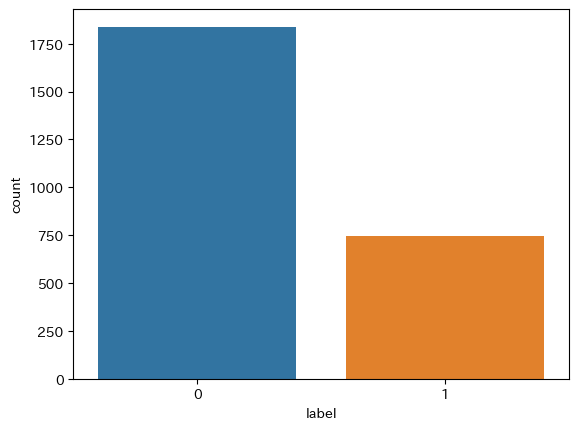

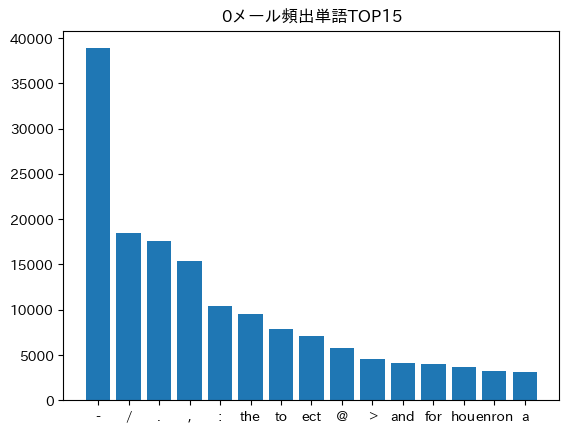

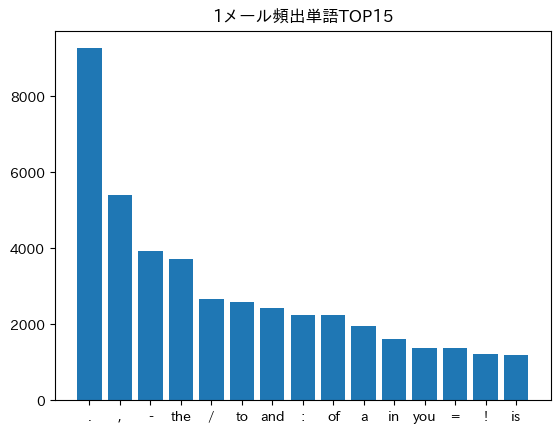

In [6]:
# =========================
# 3. EDA（文字数・単語数・頻出単語）
# =========================
train['text_length'] = train['text'].apply(len)
train['num_words'] = train['text'].apply(lambda x: len(x.split()))
test['text_length'] = test['text'].apply(len)
test['num_words'] = test['text'].apply(lambda x: len(x.split()))

# ラベル分布
sns.countplot(x=train['label'], data=train)
plt.show()

# 単語頻度の可視化（spam/ham）
def plot_top_words(df, label, top_n=15):
    corpus = [word for text in df[df['label']==label]['text'] for word in text.split()]
    dic = defaultdict(int)
    for w in corpus:
        dic[w] += 1
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]
    x, y = zip(*top)
    plt.bar(x, y)
    plt.title(f'{label}メール頻出単語TOP{top_n}')
    plt.show()

plot_top_words(train, 0)  # ham
plot_top_words(train, 1)  # spam


In [7]:
# =========================
# 4. 前処理（小文字化・ストップワード除去・ステミング）
# =========================
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

stop_words = stopwords.words('english')

def remove_stopwords(text):
    return " ".join([re.sub('[^a-zA-Z]+', '', w) for w in text.split() if w not in stop_words])

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

stemmer = SnowballStemmer("english", True)

def stemmed_words(text):
    words = word_tokenize(text)
    return " ".join([stemmer.stem(w) for w in words])

train['text_remove'] = train['text'].apply(remove_stopwords).apply(stemmed_words)
test['text_remove'] = test['text'].apply(remove_stopwords).apply(stemmed_words)

# 元のtext列は削除
train = train.drop(['text'], axis=1)
test = test.drop(['text'], axis=1)


In [8]:
# =========================
# 5. 特徴量作成（CountVectorizer）
# =========================
X = train['text_remove']
y = train['label']

count_vectorizer = CountVectorizer()
X_vec = count_vectorizer.fit_transform(X).toarray()
test_array = count_vectorizer.transform(test['text_remove']).toarray()


In [9]:
# =========================
# 6. 学習（StratifiedKFold）＋評価
# =========================
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_gnb_valid_list = []
f1_mnb_valid_list = []

for train_index, valid_index in kf.split(X_vec, y):
    X_train, X_valid = X_vec[train_index], X_vec[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    gnb = GaussianNB()
    mnb = MultinomialNB()

    gnb.fit(X_train, y_train)
    mnb.fit(X_train, y_train)

    gnb_valid_pred = gnb.predict(X_valid)
    mnb_valid_pred = mnb.predict(X_valid)

    f1_gnb_valid_list.append(f1_score(y_valid, gnb_valid_pred))
    f1_mnb_valid_list.append(f1_score(y_valid, mnb_valid_pred))

print("gnb valid mean F1:", np.mean(f1_gnb_valid_list))
print("mnb valid mean F1:", np.mean(f1_mnb_valid_list))


gnb valid mean F1: 0.9155878799629896
mnb valid mean F1: 0.9528779778165208


In [10]:
# =========================
# 7. 提出用モデル学習＆予測
# =========================
final_model = MultinomialNB()
final_model.fit(X_vec, y)

test_vec = count_vectorizer.transform(test['text_remove']).toarray()
test_pred = final_model.predict(test_vec)

submit = pd.read_csv('/コンペ/スパムメール分類コンペ/ファイル/sample_submit.csv', header=None)
submit[1] = test_pred
submit.to_csv('submission_final.csv', header=None, index=False)
